<a href="https://colab.research.google.com/github/glatham1/ECGR_4105_MachineLearning/blob/main/Homework5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Training with SGD optimizer at learning rate: 0.1
Epoch 500, Loss 1682.2796630859375
Epoch 1000, Loss 1658.755859375
Epoch 1500, Loss 1645.68359375
Epoch 2000, Loss 1636.768798828125
Epoch 2500, Loss 1633.071044921875
Epoch 3000, Loss 1631.8231201171875
Epoch 3500, Loss 1632.2379150390625
Epoch 4000, Loss 1633.707763671875
Epoch 4500, Loss 1633.03125
Epoch 5000, Loss 1632.47021484375

Training with SGD optimizer at learning rate: 0.01
Epoch 500, Loss 89716.6015625
Epoch 1000, Loss 89666.0703125
Epoch 1500, Loss 89618.1796875
Epoch 2000, Loss 89572.59375
Epoch 2500, Loss 89530.7421875
Epoch 3000, Loss 89490.140625
Epoch 3500, Loss 89452.84375
Epoch 4000, Loss 89417.65625
Epoch 4500, Loss 89384.8671875
Epoch 5000, Loss 89354.53125

Training with SGD optimizer at learning rate: 0.001
Epoch 500, Loss 226.31874084472656
Epoch 1000, Loss 220.94862365722656
Epoch 1500, Loss 215.97573852539062
Epoch 2000, Loss 211.32765197753906
Epoch 2500, Loss 206.96205139160156
Epoch 3000, Loss 202.8461761

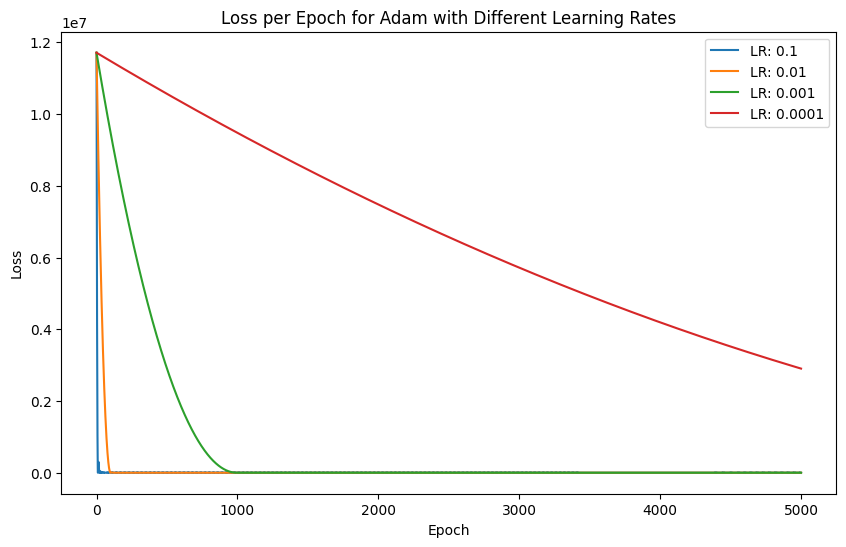

Epoch 500, Loss 2914827.0
Epoch 1000, Loss 54.685420989990234
Epoch 1500, Loss 3.5900423526763916
Epoch 2000, Loss 3.572570562362671
Epoch 2500, Loss 3.504382848739624
Epoch 3000, Loss 3.3391592502593994
Epoch 3500, Loss 3.3218507766723633
Epoch 4000, Loss 3.3399298191070557
Epoch 4500, Loss 3.3269646167755127
Epoch 5000, Loss 3.412189483642578


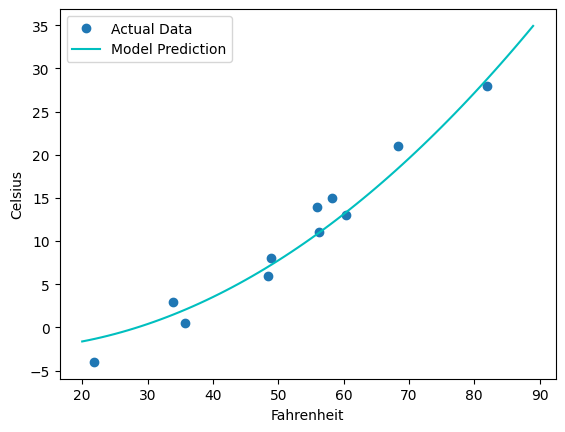

In [34]:
# Problem 1

import torch
import torch.nn as nn
from matplotlib import pyplot as plt

# Data
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

# Non-linear model
def model(t_u, w2, w1, b):
    return w2 * t_u**2 + w1 * t_u + b

# Loss function
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

# Training loop
def training_loop(n_epochs, optimizer, params, t_u, t_c, clip_value=10):
    loss_history = []
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()

        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(params, clip_value)

        optimizer.step()

        loss_history.append(loss.item())
        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss {loss.item()}')

    return loss_history

# Optimizers and learning rates
optimizers = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam
}
learning_rates = [0.1, 0.01, 0.001, 0.0001]
optimizer_losses = {}

# Determine the best optimizer
best_optimizer = None
best_lr = None
best_loss = float('inf')

for name, opt_class in optimizers.items():
    for lr in learning_rates:
        print(f'\nTraining with {name} optimizer at learning rate: {lr}')
        params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
        optimizer = opt_class([params], lr=lr)
        loss_history = training_loop(
            n_epochs=5000,
            optimizer=optimizer,
            params=params,
            t_u=t_u,
            t_c=t_c)
        final_loss = loss_history[-1]
        if final_loss < best_loss:
            best_loss = final_loss
            best_optimizer = name
            best_lr = lr
        optimizer_losses[(name, lr)] = loss_history

print(f"The best optimizer is {best_optimizer} with a learning rate of {best_lr} achieving a loss of {best_loss}")

# Plotting the losses for the best optimizer
plt.figure(figsize=(10, 6))
for (name, lr), losses in optimizer_losses.items():
    if name == best_optimizer:
        plt.plot(losses, label=f'LR: {lr}')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(f"Loss per Epoch for {best_optimizer} with Different Learning Rates")
plt.show()

# Retrain the best model with the best optimizer and learning rate
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
if best_optimizer == 'SGD':
    optimizer = torch.optim.SGD([params], lr=best_lr)
elif best_optimizer == 'Adam':
    optimizer = torch.optim.Adam([params], lr=best_lr)

loss_history = training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    params=params,
    t_u=t_u,
    t_c=t_c)

# Plotting the original data and the model's predictions
t_range = torch.arange(20., 90.).unsqueeze(1)
plt.figure()
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o', label='Actual Data')
plt.plot(t_range.numpy(), model(t_range, *params).detach().numpy(), 'c-', label='Model Prediction')
plt.legend()
plt.show()


Training with learning rate: 0.1


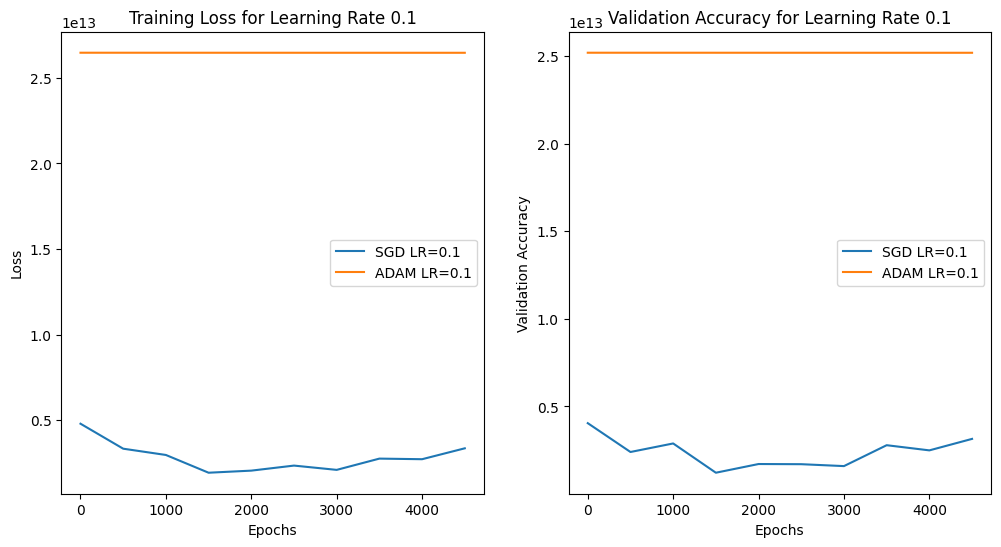

Training with learning rate: 0.01


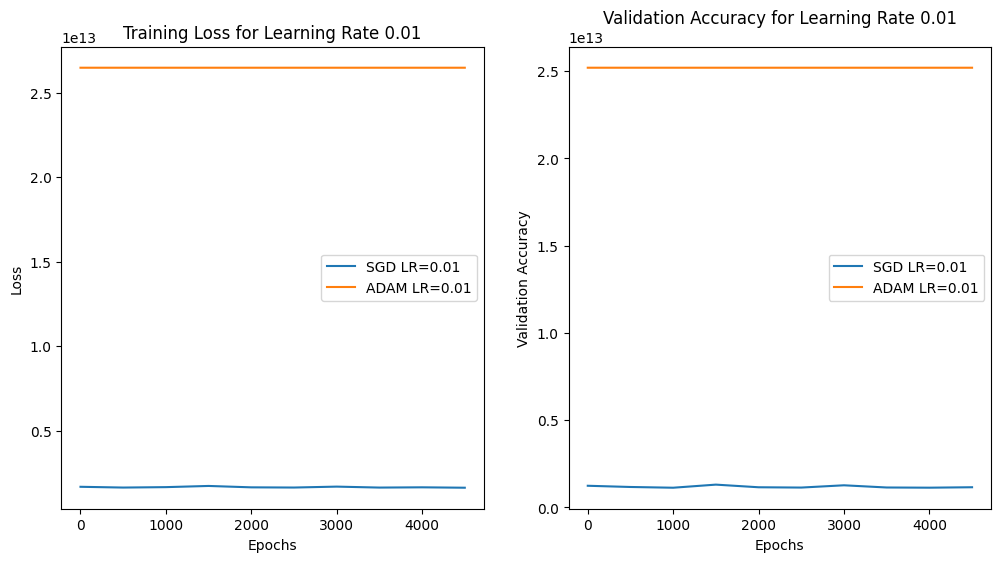

Training with learning rate: 0.001


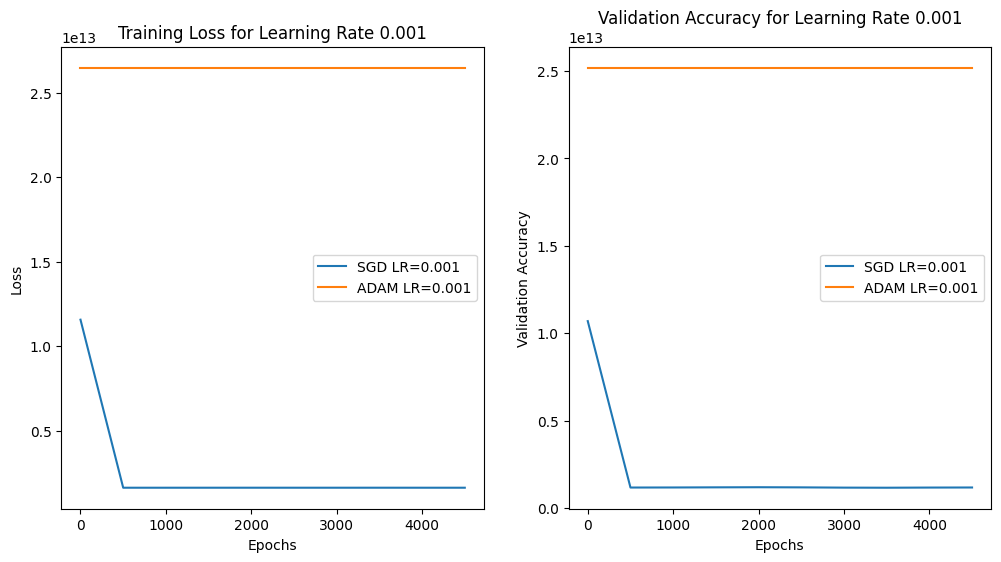

Training with learning rate: 0.0001


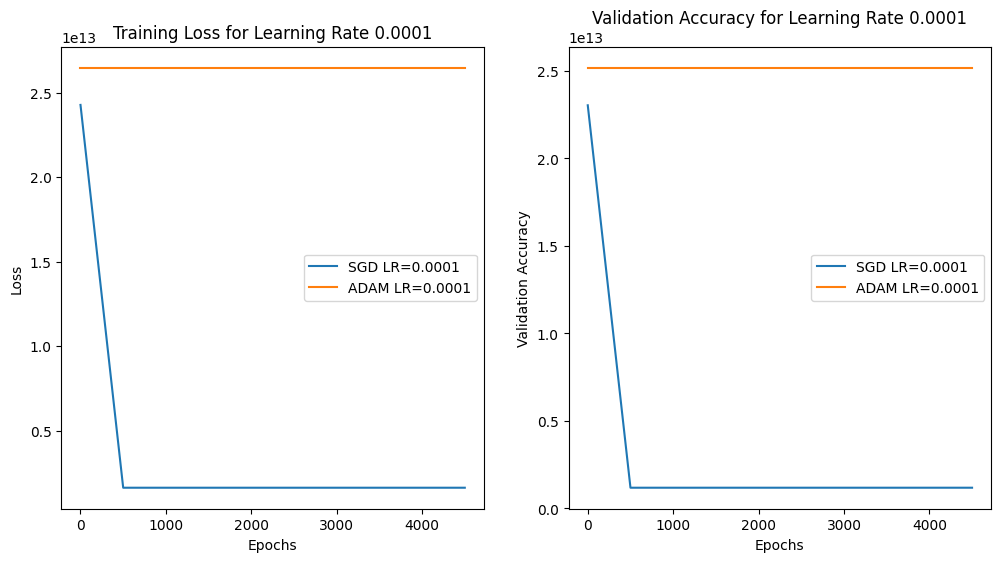

Best Model: Optimizer - sgd, Learning Rate - 0.01, Validation Accuracy - 1166437822017.021


In [25]:
# Problem 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

# Load and preprocess the dataset
df = pd.read_csv('Housing.csv')
X = df[['area', 'bedrooms', 'bathrooms', 'stories', 'parking']]
y = df['price']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Normalize the feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define the linear regression model using SGD
class LinearRegressionModel:
    def __init__(self, learning_rate, epochs, optimizer_type='sgd'):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.optimizer_type = optimizer_type

        if optimizer_type == 'sgd':
            self.model = SGDRegressor(learning_rate='constant', eta0=learning_rate, max_iter=1, warm_start=True, penalty=None)
        elif optimizer_type == 'adam':
            self.weights = np.zeros(X_train_scaled.shape[1])
            self.m = np.zeros(X_train_scaled.shape[1])
            self.v = np.zeros(X_train_scaled.shape[1])
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.epsilon = 1e-8

    def train(self, X_train, y_train, X_val, y_val):
        losses, val_accuracies = [], []
        for epoch in range(self.epochs):
            if self.optimizer_type == 'sgd':
                self.model.partial_fit(X_train, y_train)
                y_pred = self.model.predict(X_train)
            else:
                # Implement ADAM optimizer step
                y_pred = np.dot(X_train, self.weights)
                gradients = -2 * np.dot(X_train.T, (y_train - y_pred)) / len(y_train)
                self.m = self.beta1 * self.m + (1 - self.beta1) * gradients
                self.v = self.beta2 * self.v + (1 - self.beta2) * (gradients ** 2)
                m_hat = self.m / (1 - self.beta1 ** (epoch + 1))
                v_hat = self.v / (1 - self.beta2 ** (epoch + 1))
                self.weights -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

            loss = mean_squared_error(y_train, y_pred)
            val_pred = self.model.predict(X_val) if self.optimizer_type == 'sgd' else np.dot(X_val, self.weights)
            val_accuracy = mean_squared_error(y_val, val_pred)

            if epoch % 500 == 0:
                losses.append(loss)
                val_accuracies.append(val_accuracy)
        return losses, val_accuracies

# Training function for both SGD and ADAM
def train_and_evaluate(learning_rate, epochs=5000):
    results = {}
    for opt in ['sgd', 'adam']:
        model = LinearRegressionModel(learning_rate, epochs, optimizer_type=opt)
        losses, val_accuracies = model.train(X_train_scaled, y_train, X_val_scaled, y_val)
        results[opt] = (losses, val_accuracies)
    return results

# Training with different learning rates
learning_rates = [0.1, 0.01, 0.001, 0.0001]

# Plotting the results
epochs_evaluated = list(range(0, 5000, 500))

# Training with different learning rates
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    results = train_and_evaluate(lr)

    # Plot losses and accuracies for SGD and ADAM
    plt.figure(figsize=(12, 6))

    # Plotting training loss
    plt.subplot(1, 2, 1)
    for optimizer in ['sgd', 'adam']:
        losses, _ = results[optimizer]
        plt.plot(epochs_evaluated, losses, label=f'{optimizer.upper()} LR={lr}')
    plt.title(f'Training Loss for Learning Rate {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting validation accuracy
    plt.subplot(1, 2, 2)
    for optimizer in ['sgd', 'adam']:
        _, val_accuracies = results[optimizer]
        plt.plot(epochs_evaluated, val_accuracies, label=f'{optimizer.upper()} LR={lr}')
    plt.title(f'Validation Accuracy for Learning Rate {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()

    plt.show()

# Initialize variables to store the best model information
best_model = None
best_optimizer = None
best_learning_rate = None
lowest_val_accuracy = float('inf')

# Iterate through each learning rate and optimizer results
for lr in learning_rates:
    results = train_and_evaluate(lr)

    for optimizer in ['sgd', 'adam']:
        _, val_accuracies = results[optimizer]
        min_val_accuracy = min(val_accuracies)

        if min_val_accuracy < lowest_val_accuracy:
            lowest_val_accuracy = min_val_accuracy
            best_model = (lr, optimizer)
            best_optimizer = optimizer
            best_learning_rate = lr

# Output the best model details
print(f"Best Model: Optimizer - {best_optimizer}, Learning Rate - {best_learning_rate}, Validation Accuracy - {lowest_val_accuracy}")


Training with learning rate: 0.1


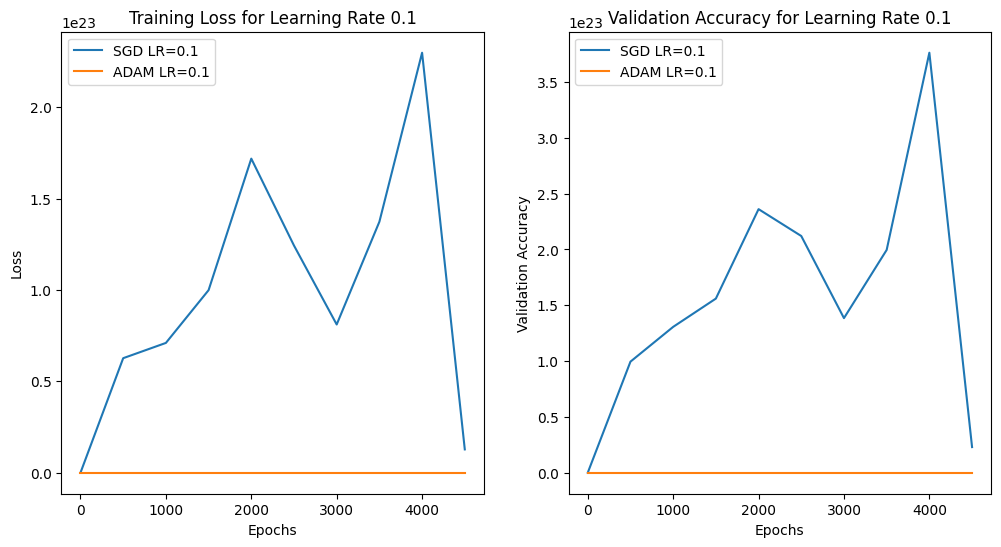

Training with learning rate: 0.01


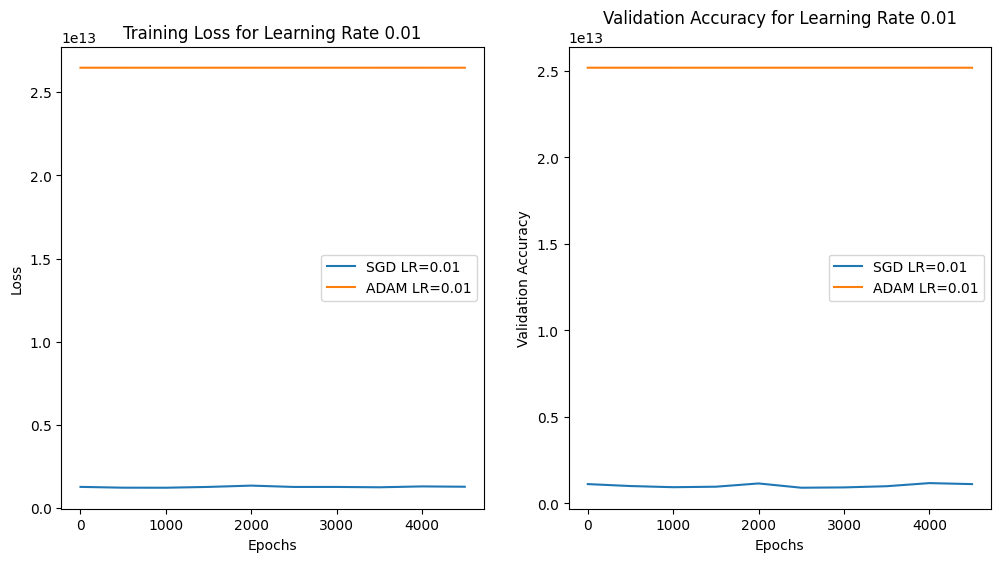

Training with learning rate: 0.001


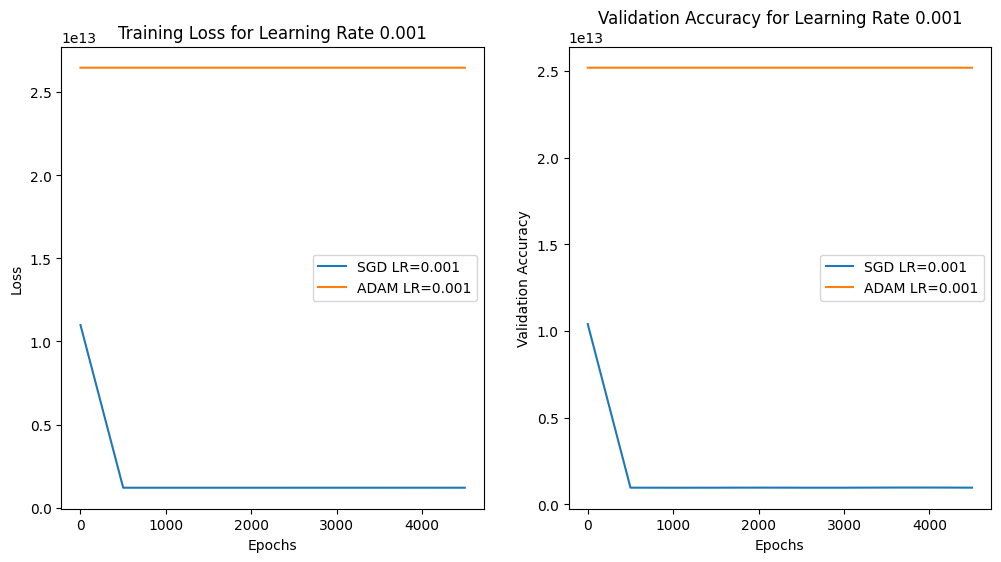

Training with learning rate: 0.0001


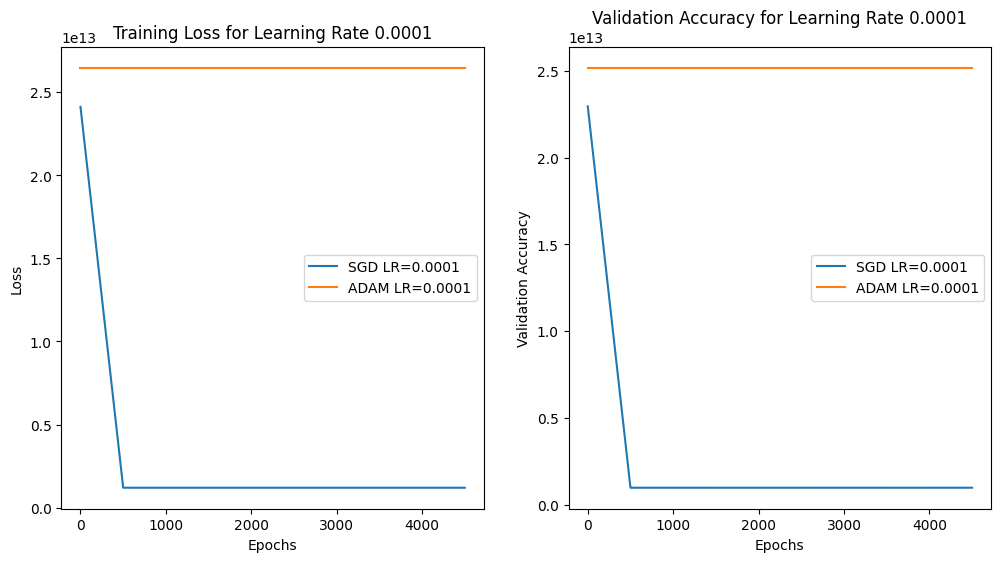

Best Model: Optimizer - sgd, Learning Rate - 0.01, Validation Accuracy - 958905909103.7393


In [35]:
# Problem 3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

# Load the data
housing = pd.read_csv('Housing.csv')

# Preprocess the data
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

varlist = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
housing[varlist] = housing[varlist].apply(binary_map)

# Selecting features and target variable
features = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea']
X = housing[features]
y = housing['price']

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Normalize the feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define the linear regression model using SGD
class LinearRegressionModel:
    def __init__(self, learning_rate, epochs, optimizer_type='sgd'):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.optimizer_type = optimizer_type

        if optimizer_type == 'sgd':
            self.model = SGDRegressor(learning_rate='constant', eta0=learning_rate, max_iter=1, warm_start=True, penalty=None)
        elif optimizer_type == 'adam':
            self.weights = np.zeros(X_train_scaled.shape[1])
            self.m = np.zeros(X_train_scaled.shape[1])
            self.v = np.zeros(X_train_scaled.shape[1])
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.epsilon = 1e-8

    def train(self, X_train, y_train, X_val, y_val):
        losses, val_accuracies = [], []
        for epoch in range(self.epochs):
            if self.optimizer_type == 'sgd':
                self.model.partial_fit(X_train, y_train)
                y_pred = self.model.predict(X_train)
            else:
                # Implement ADAM optimizer step
                y_pred = np.dot(X_train, self.weights)
                gradients = -2 * np.dot(X_train.T, (y_train - y_pred)) / len(y_train)
                self.m = self.beta1 * self.m + (1 - self.beta1) * gradients
                self.v = self.beta2 * self.v + (1 - self.beta2) * (gradients ** 2)
                m_hat = self.m / (1 - self.beta1 ** (epoch + 1))
                v_hat = self.v / (1 - self.beta2 ** (epoch + 1))
                self.weights -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

            loss = mean_squared_error(y_train, y_pred)
            val_pred = self.model.predict(X_val) if self.optimizer_type == 'sgd' else np.dot(X_val, self.weights)
            val_accuracy = mean_squared_error(y_val, val_pred)

            if epoch % 500 == 0:
                losses.append(loss)
                val_accuracies.append(val_accuracy)
        return losses, val_accuracies

# Training function for both SGD and ADAM
def train_and_evaluate(learning_rate, epochs=5000):
    results = {}
    for opt in ['sgd', 'adam']:
        model = LinearRegressionModel(learning_rate, epochs, optimizer_type=opt)
        losses, val_accuracies = model.train(X_train_scaled, y_train, X_val_scaled, y_val)
        results[opt] = (losses, val_accuracies)
    return results

# Training with different learning rates
learning_rates = [0.1, 0.01, 0.001, 0.0001]

# Plotting the results
epochs_evaluated = list(range(0, 5000, 500))

# Training with different learning rates
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    results = train_and_evaluate(lr)

    # Plot losses and accuracies for SGD and ADAM
    plt.figure(figsize=(12, 6))

    # Plotting training loss
    plt.subplot(1, 2, 1)
    for optimizer in ['sgd', 'adam']:
        losses, _ = results[optimizer]
        plt.plot(epochs_evaluated, losses, label=f'{optimizer.upper()} LR={lr}')
    plt.title(f'Training Loss for Learning Rate {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting validation accuracy
    plt.subplot(1, 2, 2)
    for optimizer in ['sgd', 'adam']:
        _, val_accuracies = results[optimizer]
        plt.plot(epochs_evaluated, val_accuracies, label=f'{optimizer.upper()} LR={lr}')
    plt.title(f'Validation Accuracy for Learning Rate {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()

    plt.show()

# Initialize variables to store the best model information
best_model = None
best_optimizer = None
best_learning_rate = None
lowest_val_accuracy = float('inf')

# Iterate through each learning rate and optimizer results
for lr in learning_rates:
    results = train_and_evaluate(lr)

    for optimizer in ['sgd', 'adam']:
        _, val_accuracies = results[optimizer]
        min_val_accuracy = min(val_accuracies)

        if min_val_accuracy < lowest_val_accuracy:
            lowest_val_accuracy = min_val_accuracy
            best_model = (lr, optimizer)
            best_optimizer = optimizer
            best_learning_rate = lr

# Output the best model details
print(f"Best Model: Optimizer - {best_optimizer}, Learning Rate - {best_learning_rate}, Validation Accuracy - {lowest_val_accuracy}")
